In [1]:
%reload_ext autoreload
%autoreload 2

In [9]:
ls *load*

biomag_download_info.ipynb  download_output.txt


In [18]:
ls /mnt/hcp-meg/105923/

rest-run0-preproc-raw.fif  rest-run1-preproc-raw.fif  rest-run2-preproc-raw.fif


In [538]:
import os.path as op
import mne

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import hcp
from hcp import preprocessing as preproc
from hcp import io

from scipy.signal import welch
import numpy as np

from sklearn.linear_model import LinearRegression

In [44]:
sns.set_style('ticks')

In [20]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 

In [23]:
recordings_path = '/mnt/hcp-meg'
subject = '105923'

In [24]:
fname = op.join(recordings_path, subject, 'rest-run0-preproc-raw.fif')

In [96]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.


<ipython-input-96-826c3e305aa6>:1: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


In [97]:
raw.load_data()

Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [98]:
def _preprocess_raw(raw, hcp_params, ica_sel):
    # construct MNE annotations
    annots = hcp.read_annot(**hcp_params)
    bad_seg = (annots['segments']['all']) / raw.info['sfreq']
    annotations = mne.Annotations(
        bad_seg[:, 0], (bad_seg[:, 1] - bad_seg[:, 0]),
        description='bad')

    raw.annotations = annotations
    raw.info['bads'] += annots['channels']['all']
    raw.pick_types(meg=True, ref_meg=False)

    # read ICA and remove EOG ECG or keep brain components
    ica_mat = hcp.read_ica(**hcp_params)
    if ica_sel == 'ecg_eog':
        exclude = annots['ica']['ecg_eog_ic']
    elif ica_sel == 'brain':
        exclude = [ii for ii in range(annots['ica']['total_ic_number'][0])
                   if ii not in annots['ica']['brain_ic_vs']]

    preproc.apply_ica_hcp(raw, ica_mat=ica_mat, exclude=exclude)
    # add back missing channels
    raw = preproc.interpolate_missing(raw, **hcp_params)
    return raw

In [99]:
hcp_params = dict(subject=subject, hcp_path=op.join('/mnt', 'HCP'),
                  data_type='rest')

raw = _preprocess_raw(raw, hcp_params=hcp_params, ica_sel='ecg_eog')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Creating RawArray with float64 data, n_channels=248, n_times=749070
Current compensation grade : 0
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 84 missing 0.0001]


In [622]:
1/2048. * (2 ** 18)

128.0

In [623]:
freqs, psd = welch(raw[100][0], nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear')

## works with with natural log

6.24416690066


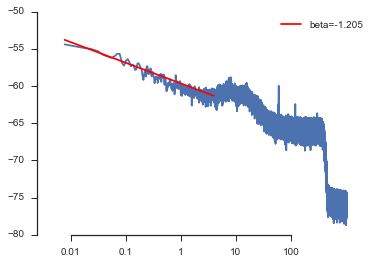

In [624]:
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log(freqs[fmask][:, None]),
   np.log(psd.T[fmask]),
   )
frange = np.log(freqs[fmask].max()) - np.log(freqs[fmask].min())
print(frange)
plt.figure()
plt.plot(np.log(freqs), np.log(psd.T))
plt.plot(np.log(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log([0.01, 0.1, 1, 10, 100]),
                  [0.01, 0.1, 1, 10, 100])
sns.despine(trim=True)

## works with with decadic log

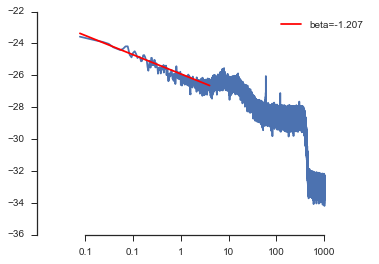

In [629]:
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)

## beta estimates as a function of window length

In [705]:
'%d' % n_fft

'4096'

In [851]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

In [852]:
mean_squared_error(lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))

0.10462992005716513

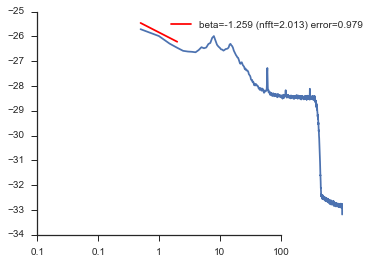

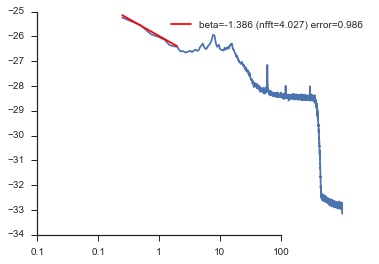

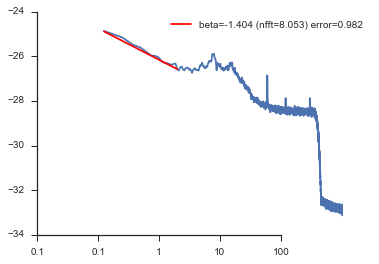

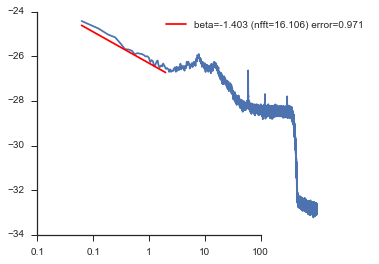

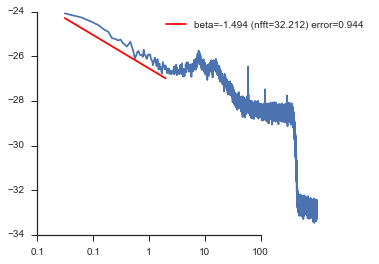

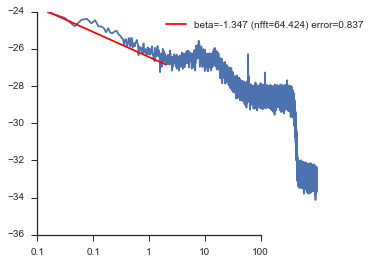

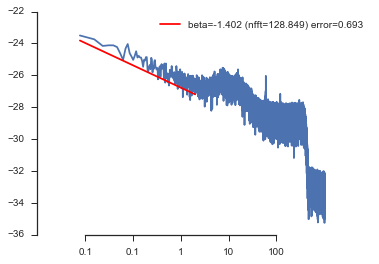

In [855]:
for exp in [12, 13, 14, 15, 16, 17, 18]:
    n_fft = 2 ** exp
    freqs, psd = welch(raw[100][0], nperseg=(n_fft), fs=raw.info['sfreq'], detrend='constant',
                       noverlap=0)
    fmask = (freqs <= 2) & (freqs > 0)
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]),
       np.log10(psd.T[fmask]),
       )
    score = r2_score(
        lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    plt.figure()
    plt.plot(np.log10(freqs), np.log10(psd.T))
    plt.plot(np.log10(freqs[fmask][[0, -1]]),
             np.array([lm.intercept_,
                       lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
             label='beta=%0.3f (nfft=%0.3f) r2=%0.3f' % (
                lm.coef_[0], 1./raw.info['sfreq'] * n_fft, score))
    plt.legend(loc='best')
    plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
    sns.despine(trim=True)
    

## Use FFT without windowing

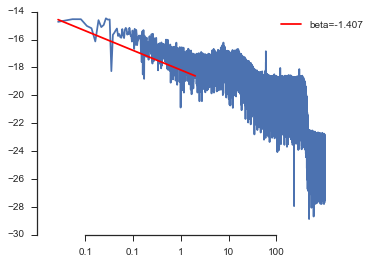

In [710]:
from scipy import fft, fftpack

freqs = fftpack.fftfreq(len(raw[100][0][0]), raw.times[1] - raw.times[0])
freqs = freqs[:freqs.size/2]

psd = fftpack.fft(raw[100][0][0])
psd = np.abs(psd[:psd.size/2][None, :]) ** 2

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## an improved welch estimator

Use epoching functionality to get the good data segments, then apply windowing manually prior to FFT computation.
Shortcut: drop bad epochs, reconstruct raw data and then use the scipy function.

We see that with zero overlap the solutions are equivalent

In [810]:
n_fft

4096

In [832]:
n_fft = 2**15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped


In [833]:
raw2 = mne.io.RawArray(info=epochs.info, data=np.hstack(epochs.get_data()))

Creating RawArray with float64 data, n_channels=248, n_times=425997
Current compensation grade : 0
    Range : 0 ... 425996 =      0.000 ...   209.385 secs
Ready.


In [834]:
print(raw.times.shape, raw2.times.shape)

((749070,), (425997,))


In [835]:
psd1, freqs = mne.time_frequency.psd_welch(raw, n_fft=n_fft, picks=[100], n_overlap=0)
psd2, freqs = mne.time_frequency.psd_welch(raw2, n_fft=n_fft, picks=[100], n_overlap=0)
psd3_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, picks=[100], n_overlap=0)
psd3 = psd3_epochs.mean(0)

Effective window size : 16.106 (s)
Effective window size : 16.106 (s)
Effective window size : 16.106 (s)


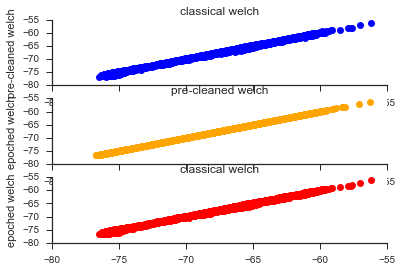

In [836]:
fig, axs = plt.subplots(3, 1, sharex=False)
axs[0].plot(np.log(psd1.ravel()), np.log(psd2.ravel()),
            linewidth=0, marker='o', color='blue')
axs[0].set_title('classical welch')
axs[0].set_ylabel('pre-cleaned welch')

axs[1].plot(np.log(psd3.ravel()), np.log(psd2.ravel()),
            linewidth=0, marker='o', color='orange')
axs[1].set_title('pre-cleaned welch')
axs[1].set_ylabel('epoched welch')

axs[2].plot(np.log(psd1.ravel()), np.log(psd3.ravel()),
            linewidth=0, marker='o', color='red')
axs[2].set_title('classical welch')
axs[2].set_ylabel('epoched welch')

sns.despine(trim=True)
plt.show()

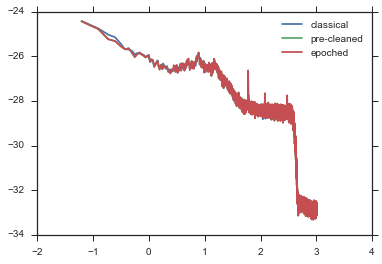

In [839]:
plt.plot(np.log10(freqs), np.log10(psd1).T, label='classical')
plt.plot(np.log10(freqs), np.log10(psd2).T, label='pre-cleaned')
plt.plot(np.log10(freqs), np.log10(psd3).T, label='epoched')
plt.legend()

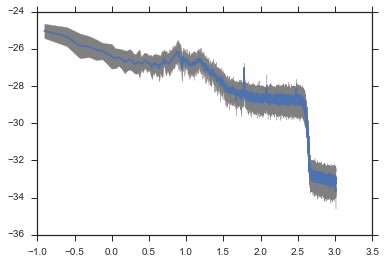

In [831]:
psd_std = np.log10(psd3_epochs).std(0).T
psd_mean = np.log10(psd3_epochs).mean(0).T

plt.fill_between(np.log10(freqs), (psd_mean + psd_std).ravel(),
                                   (psd_mean - psd_std).ravel(), color='gray')
plt.plot(np.log10(freqs), psd_mean)

In [999]:
vals = list()
for exp in [12, 13, 14, 15, 16, 17]:
    n_fft = 2 ** exp
    freqs, psd = welch(raw[100][0], nperseg=(n_fft), fs=raw.info['sfreq'], detrend='constant',
                       noverlap=0)

    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    
    fmask = (freqs <= 2) & (freqs > 0)
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]),
       np.log10(psd.T[fmask]),
       )
    scores = [r2_score(x, y) for x, y in zip(
              lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))]
    vals.append((n_fft, scores, lm.coef_.ravel(), freqs[fmask][0]))

182 matching events found
No baseline correction applied
0 projection items activated
Loading data for 182 events and 4097 original time points ...
40 bad epochs dropped
Effective window size : 2.013 (s)
91 matching events found
No baseline correction applied
0 projection items activated
Loading data for 91 events and 8193 original time points ...
23 bad epochs dropped
Effective window size : 4.027 (s)
45 matching events found
No baseline correction applied
0 projection items activated
Loading data for 45 events and 16385 original time points ...
14 bad epochs dropped
Effective window size : 8.053 (s)
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
11 matching events found
No baseline correction applied
0 projection items activated
Loading data for 11 events and 65537 original time points ...
7 bad epochs dropped
Effective window siz

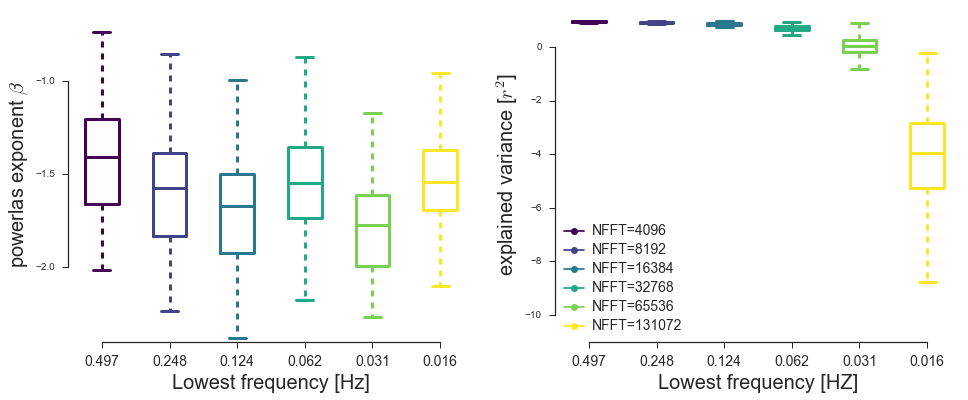

In [1034]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

bplots = [axs[0].boxplot([v[2] for v in vals]),
          axs[1].boxplot([v[1] for v in vals])]
axs[0].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[1].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[0].set_xlabel('Lowest frequency [Hz]', fontsize=20)
axs[1].set_xlabel('Lowest frequency [HZ]', fontsize=20)
axs[0].set_ylabel(r'powerlas exponent $\beta$ ', fontsize=20)
axs[1].set_ylabel(r'explained variance [$r^2$]', fontsize=20)
axs[0].set_xlim(0.5, 6.5)
axs[1].set_xlim(0.5, 6.5)
axs[1].set_ylim(-11, 1.5)


all_colors = [[plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))],
              [plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))]]

[axs[1].plot(42, 42, label='NFFT=%d' % v[0], color=c, marker='o')
 for v, c in zip(vals, all_colors[1])]
lg = axs[1].legend(loc='best')
[tt.set_fontsize(14) for tt in lg.get_texts()]

for bb, bplot in enumerate(bplots, 0):
    colors = all_colors[bb]
    for k, elems in bplot.items():
        for jj, el in enumerate(elems):
            if len(elems) == len(colors):
                this_colors = colors[:]
            else:
                this_colors = sum([[c, c] for c in colors], [])
            if hasattr(el, 'set_color'):
                el.set_color(this_colors[jj])
                el.set_linewidth(3)
sns.despine(trim=True)

fig.savefig('paper_figures/paper_fig_beta_est_choice.png', dpi=600)

In [1008]:
mkdir paper_figures 

[None, None, None, None, None, None]